# CFRM421 Final Project 
**Contributor:** Yueying Du

## Overview
This project focuses on predicting next‐second stock returns using the Optiver “Trading at the Close” dataset from Kaggle. I explore two main approaches:
1. **LightGBM regression** with both core and derived features.  
2. **1D CNN** to capture short‐term temporal patterns in a sliding‐window fashion.

## Data Preparation
- Load `train.csv`, compute per‐second “index” as the day‐wide mean of WAP, and create a scaled “delta” feature.  
- Split the first 400 unique dates for training and the remaining dates for validation.  

## Modeling Steps
1. **LightGBM Baseline**  
   - Use 11 core features to train a baseline model.  
   - Evaluate RMSE and MAE on validation.  
2. **LightGBM with Derived Features**  
   - Add 6 new features to capture liquidity and volatility patterns.  
   - Observe MAE decrease compared to the baseline.  
3. **1D CNN Experiment**  
   - Standardize selected features and build sliding‐window datasets.  
   - Define a simple two‐layer 1D CNN, train with early stopping, and report RMSE/MAE on validation.

## Results Summary
- **Baseline LightGBM (11 features)**: Validation MAE ≈ 5.925.  
- **LightGBM + derived features**: Validation MAE reduced to ≈ 5.922.  
- **1D CNN**: Validation MAE ≈ 5.993 (comparable but not better than LightGBM).



## 1. Data Loading and Initial Inspection


In [30]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv("train.csv")

# Count how many unique dates are in the dataset
unique_dates = df["date_id"].nunique()
print("Number of unique date_id values:", unique_dates)

# Sort all unique date_id values
unique_dates = sorted(df["date_id"].unique())

# Use the first 400 dates for training, the rest for validation
train_dates = unique_dates[:400]
val_dates = unique_dates[400:]

# Compute the average 'wap' per date_id and seconds_in_bucket as an index
index_df = (df.groupby(['date_id', 'seconds_in_bucket'])['wap'].mean().reset_index())
index_df.rename(columns={'wap': 'index'}, inplace=True)

# Merge the index back into the main DataFrame
df = pd.merge(df, index_df, how='left', on=['date_id', 'seconds_in_bucket'])

# Create a 'delta' feature: scaled difference between 'wap' and the index
df['delta'] = (df['wap'] - df['index']) / df['index'] * 10**4

# Split into training and validation sets based on date_id
df_train = df[df["date_id"].isin(train_dates)]
df_val = df[df["date_id"].isin(val_dates)]

# Remove rows where 'target' is NaN
df_train = df_train[~df_train["target"].isna()]
df_val = df_val[~df_val["target"].isna()]

# Define the list of features to use for the model
feature_columns = [
    'seconds_in_bucket',
    'imbalance_size',
    'imbalance_buy_sell_flag',
    'reference_price',
    'matched_size',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'delta'
]

# Create training input (X) and target (y) from the filtered training DataFrame
X_train = df_train[feature_columns]
y_train = df_train["target"]

# Create validation input (X) and target (y) from the filtered validation DataFrame
X_val = df_val[feature_columns]
y_val = df_val["target"]

Number of unique date_id values: 481


## 2. LightGBM 
### 2.1 LightGBM Baseline

In [36]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize a LightGBM regressor
model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    learning_rate=0.03,
    num_leaves=31,
    n_estimators=2000,
    min_child_samples=50,
    lambda_l1=0.5,
    lambda_l2=0.5,
    random_state=42,
    n_jobs=-1
)

# Train the model with early stopping and logging evaluation results
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=150, verbose=True),
        log_evaluation(period=150)
    ]
)

# Make predictions on the validation set
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(f"Validation RMSE: {rmse:.4f}")

mae_baseline = mean_absolute_error(y_val, y_pred)
print(f"Baseline LGBM Val MAE: {mae_baseline:.4f}")

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2353
[LightGBM] [Info] Number of data points in the train set: 4346893, number of used features: 11
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start 

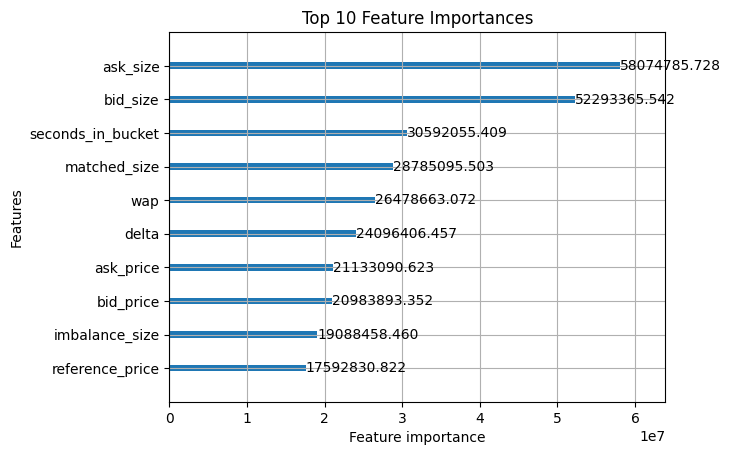

In [37]:
import matplotlib.pyplot as plt
from lightgbm import plot_importance

# Plot the top 10 feature importances by gain
plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances")
plt.show()

### 2.2 LighGBM with Derived Features

In [38]:
# Add derived features

# Liquidity ratio features
df['liq_ratio_1'] = df['ask_size'] / (df['ask_size'] + df['bid_size'])
df['liq_ratio_2'] = (df['ask_size'] - df['bid_size']) / (df['ask_size'] + df['bid_size'])
df.loc[(df['ask_size'] + df['bid_size']) == 0, ['liq_ratio_1', 'liq_ratio_2']] = 0.0

# Price spread features
df['price_spread'] = df['ask_price'] - df['bid_price']
df['abs_price_spread'] = df['price_spread'].abs()

# Rolling statistics for WAP within each date_id
df = df.sort_values(['date_id', 'seconds_in_bucket']).reset_index(drop=True)
df['wap_roll_mean_3'] = (df.groupby('date_id')['wap']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
df['wap_roll_std_3'] = (df.groupby('date_id')['wap']
    .transform(lambda x: x.rolling(window=3, min_periods=1).std())
)
# Fill NaN values resulting from rolling with zero
df['wap_roll_std_3'] = df['wap_roll_std_3'].fillna(0.0)


In [40]:
# Split into training and validation sets, then drop rows with missing target
unique_dates = sorted(df["date_id"].unique())
train_dates = unique_dates[:400]
val_dates = unique_dates[400:]

df_train = df[df["date_id"].isin(train_dates)].copy()
df_val = df[df["date_id"].isin(val_dates)].copy()

df_train = df_train[~df_train["target"].isna()].reset_index(drop=True)
df_val = df_val[~df_val["target"].isna()].reset_index(drop=True)


In [41]:
# Train LightGBM including derived features as model inputs
core_features = [
    'ask_size', 'bid_size', 'seconds_in_bucket',
    'matched_size', 'delta', 'wap', 'imbalance_size'
]
derived_features = [
    'liq_ratio_1', 'liq_ratio_2',
    'price_spread', 'abs_price_spread',
    'wap_roll_mean_3', 'wap_roll_std_3'
]

all_features = core_features + derived_features

X_train_all = df_train[all_features]
y_train_all = df_train['target']

X_val_all = df_val[all_features]
y_val_all = df_val['target']

model_all = LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    learning_rate=0.03,
    num_leaves=31,
    n_estimators=2000,
    min_child_samples=50,
    lambda_l1=0.5,
    lambda_l2=0.5,
    random_state=42,
    n_jobs=-1
)

model_all.fit(
    X_train_all, y_train_all,
    eval_set=[(X_train_all, y_train_all), (X_val_all, y_val_all)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=150, verbose=False),
        log_evaluation(period=150)
    ]
)

#Compute and print RMSE on training and validation sets (all features)
y_train_pred_all = model_all.predict(X_train_all)
mse_train_all = mean_squared_error(y_train_all, y_train_pred_all)
rmse_train_all = np.sqrt(mse_train_all)

y_val_pred_all = model_all.predict(X_val_all)
mse_val_all = mean_squared_error(y_val_all, y_val_pred_all)
rmse_val_all = np.sqrt(mse_val_all)

print(f"Train RMSE: {rmse_train_all:.4f}")
print(f"Val RMSE: {rmse_val_all:.4f}")

mae_all = mean_absolute_error(y_val_all, y_val_pred_all)
print(f"LGBM Val MAE: {mae_all:.4f}")


[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 4346893, number of used features: 13
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start 

**By including these derived features, the model captures intraday liquidity dynamics and short‐term price volatility more effectively. As a result, validation MAE decreased compared to the baseline model without derived features.**

## 3. CNN 

- **Data Preparation**  
  First I standardized a few key numerical features and then created fixed‐length windows of 20 consecutive time steps. Each window serves as one input sample, with its label being the target value at the next time step.

- **Model Structure**  
  The network consists of two 1D convolutional layers, followed by global average pooling, a small dense layer with dropout, and a final output neuron for regression.

- **Training Setup**  
  I used an Adam optimizer with a reduced learning rate (0.0005), mean squared error loss, and early stopping to prevent overfitting. Batch size was set to 1024, and training ran for up to 10 epochs.

- **Outcome**  
  On the validation set, the CNN achieved an RMSE around 9 and MAE around 6.


In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Select features for the CNN
seq_cols = [
    'ask_size', 'bid_size', 'wap', 'delta',
    'liq_ratio_1', 'liq_ratio_2', 'price_spread', 'abs_price_spread'
]

# Drop rows with missing values and standardize
df_train = df_train.dropna(subset=seq_cols + ['target']).reset_index(drop=True)
df_val = df_val.dropna(subset=seq_cols + ['target']).reset_index(drop=True)

scaler = StandardScaler()
df_train[seq_cols] = scaler.fit_transform(df_train[seq_cols])
df_val[seq_cols] = scaler.transform(df_val[seq_cols])

def build_cnn_input(df, seq_cols, seq_len=10):
    X_list, y_list = [], []
    df_sorted = df.sort_values(['date_id', 'seconds_in_bucket']).reset_index(drop=True)
    for date_id in df_sorted['date_id'].unique():
        sub = df_sorted[df_sorted['date_id'] == date_id].reset_index(drop=True)
        data_mat = sub[seq_cols].values
        targets  = sub['target'].values
        for i in range(seq_len, len(sub)):
            X_list.append(data_mat[i-seq_len:i, :])
            y_list.append(targets[i])
    return np.array(X_list), np.array(y_list)

seq_len = 15
X_train_cnn, y_train_cnn = build_cnn_input(df_train, seq_cols, seq_len=seq_len)
X_val_cnn, y_val_cnn = build_cnn_input(df_val, seq_cols, seq_len=seq_len)

num_features = len(seq_cols)

# Build the CNN model
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(seq_len, num_features)),
    BatchNormalization(),
    Conv1D(32, 3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Use a smaller learning rate for Adam
optimizer = Adam(learning_rate=5e-4)
cnn_model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=10,
    batch_size=512,
    callbacks=[early_stop],
    verbose=2
)

# Make predictions on the validation set
y_val_pred = cnn_model.predict(X_val_cnn).flatten()

/Users/jiaqiao/Downloads/CFRM421/Final_Project/cfrm421-finalproj/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4240/4240 - 74s - 18ms/step - loss: 91.2592 - val_loss: 79.9576
Epoch 2/10
4240/4240 - 69s - 16ms/step - loss: 91.2372 - val_loss: 79.9480
Epoch 3/10
4240/4240 - 78s - 18ms/step - loss: 91.2285 - val_loss: 79.9502
Epoch 4/10
4240/4240 - 82s - 19ms/step - loss: 91.2158 - val_loss: 79.9695
27805/27805 ━━━━━━━━━━━━━━━━━━━━ 11s 402us/step


In [14]:
# Align lengths of true and predicted arrays
m = min(len(y_val_cnn), len(y_val_pred))
y_true_aligned = y_val_cnn[:m]
y_pred_aligned = y_val_pred[:m]

# Compute RMSE using numpy
rmse = np.sqrt(np.nanmean((y_true_aligned - y_pred_aligned) ** 2))
print(f"CNN Val RMSE: {rmse:.4f}")

# Compute MAE using sklearn
mae = mean_absolute_error(y_true_aligned, y_pred_aligned)
print(f"CNN Val MAE: {mae:.4f}")

CNN Val RMSE: 8.9414
CNN Val MAE: 5.9931


## Conclusions and Next Steps

- **Why I didn’t blend CNN with LightGBM:**
Aligning the CNN outputs (which use sliding windows) with the LightGBM row-wise predictions requires keeping track of the exact row indices for each CNN sample. That index alignment logic is a bit complex and would take extra code to ensure every CNN prediction matches the correct LightGBM prediction. Therefore, I simply report the standalone CNN performance (MAE ≈ 5.99) and skip the blending step.





